In [1]:
 #!/usr/bin/python3
# coding: utf-8
# @Time    : 2020/10/29 17:37

import numpy as np
import random

import torch
import torch.nn as nn

# set random seed
SEED = 20202020

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('weak supervision task device', device)
eps=1e-6

def hetro_loss(x, mu, v):
    return (((x - mu) ** 2 / v) + torch.log(v)).mean()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = y_true.cpu().numpy(), y_pred.cpu().numpy()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_rmse(y_true, y_pred):
    y_true, y_pred = y_true.cpu().numpy(), y_pred.cpu().numpy()
    return np.sqrt(((y_true/60 - y_pred/60) ** 2).mean())

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train(model,optimizer,epoch,batch_size, train_data):

    train_path, train_ratio, train_slots, train_orderid, train_label =train_data
    road_idx=torch.tensor(list(range(num_locations))).to(device)
    time_idx=torch.tensor(list(range(num_times))).to(device)       
    model.train()
    tte_loss,speed_loss=0.0,0.0,0.0,0.0,0.0
    for i in range(0, train_path.shape[0],batch_size):
        paths_temp,ratio_temp,time_temp=train_path[i:i+batch_size],train_ratio[i:i+batch_size],train_slots[i:i+batch_size]
        optimizer.zero_grad()
        entire_out,mu,sigma=model(road_idx,time_idx,time_temp,g2,u,lengths,paths_temp,edge_type)
            # add 1
        
        mu=torch.cat([mu,torch.zeros(1,mu.shape[1]).to(device)])
        sigma=torch.cat([sigma,torch.zeros(1,sigma.shape[1]).to(device)])
        t=train_slots[i:i+batch_size]
        
        path_mu,path_sigma=mu[paths_temp],sigma[paths_temp]
        path_mu_new,path_mu_path_sigma=[],[]
        for o,l in enumerate(t):
            path_mu_new.append(path_mu[o:o+1,:,l])
            path_mu_path_sigma.append(path_sigma[o:o+1,:,l])
        path_mu,path_sigma=torch.cat(path_mu_new),torch.cat(path_mu_path_sigma)
    
        E_mu=torch.mul(path_mu,ratio_temp).sum(dim=1)+eps
        E_sigma=torch.mul(path_sigma,ratio_temp).pow(2).sum(dim=1)+eps

    
        label_time=train_label[i:i+batch_size,0:1]
        label_speed=train_label[i:i+batch_size,1]
        loss1=hetro_loss(label_speed,E_mu,E_sigma)
        loss2 = (torch.abs(entire_out - label_time) / label).mean()

        tte_loss+=torch.abs(entire_out-label_time).sum()
        speed_loss+=torch.abs(label_speed-E_mu).sum()
        
        print('\r tte loss: %f speed loss %f' %(tte_loss.item(), speed_loss), end="")

        (loss1+loss2).mean().backward()
        optimizer.step()
        optimizer.zero_grad()
    print()
    print("Epoch:",epoch, tte_loss.item(),speed_loss.item())
    return tte_loss,speed_loss

def evaluate_traveltime(model, epoch,batch_size, test_data):
    model.eval()
    tte_loss,total_output,test_samples=0.0,0.0,[],0.0
    test_path,test_ratio,test_slots,test_orderid,test_label=test_data
    with torch.no_grad():
        for i in range(0, test_path.shape[0],batch_size):
            
            paths_temp,ratios_temp,time_temp=test_path[i:i+batch_size],test_ratio[i:i+batch_size],test_slots[i:i+batch_size]
            test_samples+=paths_temp.shape[0]
            entire_out,mu,sigma=model(road_idx,time_idx,time_temp,g2,u,lengths,paths_temp,edge_type)

            label_time=test_label[i:i+batch_size,0:1]
            total_output.append(entire_out)
            tte_loss+=torch.abs(entire_out-label_time).sum().item()
        tte_loss/=test_samples
        total_output=torch.cat(total_output)
        index=torch.unique(test_orderid)
        traj_output,label=torch.zeros(len(index),1),torch.zeros(len(index),1)
        for o, idx in enumerate(index):
            #max_lens=max(len(idx.reshape(-1)),max_lens)
            traj_output[o],label[o]=total_output[test_orderid==idx].sum(),test_label[test_orderid==idx].sum()
        traj_tte_loss=torch.abs(traj_output-label).mean()
       
        mse = compute_rmse(label, traj_output)
        mape = mean_absolute_percentage_error(label, traj_output)
        print("\n Epoch: %d, Path tte loss: %.4f, traj_tte_loss: %.4f" %( epoch,tte_loss/60,traj_tte_loss/60))
        return tte_loss,traj_tte_loss,mse,mape


weak supervision task device cpu


In [2]:
from dgl.data.rdf import AIFBDataset, AMDataset, BGSDataset, MUTAGDataset

In [23]:
[n for n in g.nodes['Personen']]

[{'_ID': tensor([   5,    6,    7,    8,    9,   10,   11,   18,   19,   20,   21,   34,
           35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
           47,   48,   54,   55,   56,   57,   62,   63,   67,   68,   69,   70,
           71,   72,   73,   74,   75,   76,   82,   83,   84,   88,   89,   90,
           91,   92,   93,   94,   95,  100,  103,  106,  115,  116,  125,  126,
          129,  130,  133,  134,  135,  136,  142,  143,  144,  147,  148,  149,
          150,  166,  167,  174,  180,  183,  186,  194,  195,  196,  197,  198,
          201,  219,  220,  223,  234,  266,  267,  287,  288,  289,  303,  359,
          360,  371,  398,  414,  465,  466,  467,  468,  469,  644,  645,  776,
          777,  778,  779, 1654, 1656, 1657, 1658, 1659, 1704, 1765, 1789, 1794,
         1797, 1800, 1802, 1804, 1806, 1808, 1810, 1812, 1814, 1816, 1818, 1820,
         1822, 1828, 1830, 1832, 1834, 1836, 1838, 1840, 1842, 1846, 1848, 1850,
         1852, 1854,

In [18]:
dataset = AIFBDataset()
g = dataset[0]
category = dataset.predict_category
num_classes = dataset.num_classes
train_mask = g.nodes[category].data.pop("train_mask")
test_mask = g.nodes[category].data.pop("test_mask")
train_idx = torch.nonzero(train_mask, as_tuple=False).squeeze()
test_idx = torch.nonzero(test_mask, as_tuple=False).squeeze()
labels = g.nodes[category].data.pop("labels")
category_id = len(g.ntypes)

Done loading data from cached files.


<Axes: >

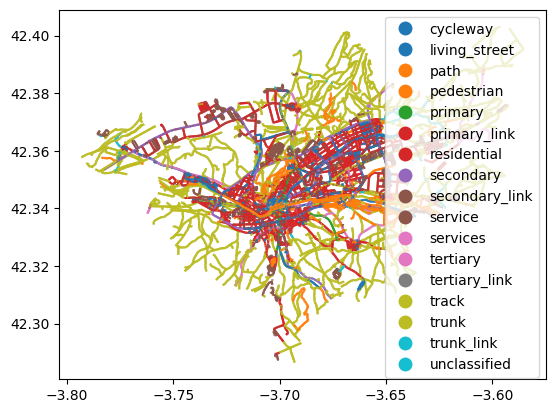

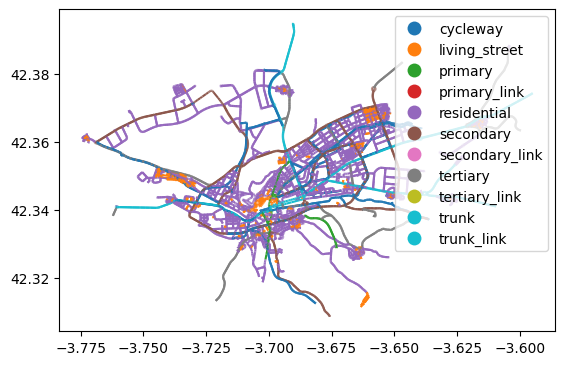

In [25]:
import networkx as nx
import osmnx as ox

# ox.settings.log_console=True

# g = ox.graph_from_place('Burgos, Spain', network_type='bike',simplify=False)

gdf_nodes, gdf_edges=ox.graph_to_gdfs(g)
gdf_edges.plot(column="highway",legend=True)

all_tags=['secondary', 'trunk', 'cycleway', 'residential', 'primary',
       'tertiary', 'trunk_link', 'service', 'track', 'secondary_link',
       'living_street', 'path', 'tertiary_link', 'pedestrian',
       'unclassified', 'primary_link', 'services']
# remove_tags=['living_street','residential','unclassified','motorway_link']
keep_tags=['secondary', 'trunk', 'cycleway', 'residential', 'primary',
       'tertiary', 'trunk_link', 'secondary_link',
       'living_street', 'tertiary_link', 'primary_link']
del_list=[]
for j,i in gdf_edges.iterrows():
    if i["highway"] not in keep_tags:
        del_list.append(j)
gdf_edges=gdf_edges.drop(index=del_list)
g=ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=None)  

largest_cc = max(nx.strongly_connected_components(g), key=len)
g = g.subgraph(largest_cc)
gdf_nodes, gdf_edges=ox.graph_to_gdfs(g)
gdf_edges.plot(column="highway",legend=True)

In [27]:
from collections import defaultdict

import dgl
import dgl.function as fn
import dgl.nn as dglnn

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import tqdm

In [ ]:
class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.

    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """

    def __init__(
        self,
        in_feat,
        out_feat,
        rel_names,
        num_bases,
        *,
        weight=True,
        bias=True,
        activation=None,
        self_loop=False,
        dropout=0.0
    ):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop

        self.conv = dglnn.HeteroGraphConv(
            {
                rel: dglnn.GraphConv(
                    in_feat, out_feat, norm="right", weight=False, bias=False
                )
                for rel in rel_names
            }
        )

        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = dglnn.WeightBasis(
                    (in_feat, out_feat), num_bases, len(self.rel_names)
                )
            else:
                self.weight = nn.Parameter(
                    th.Tensor(len(self.rel_names), in_feat, out_feat)
                )
                nn.init.xavier_uniform_(
                    self.weight, gain=nn.init.calculate_gain("relu")
                )

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(
                self.loop_weight, gain=nn.init.calculate_gain("relu")
            )

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        """Forward computation

        Parameters
        ----------
        g : DGLGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.

        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {
                self.rel_names[i]: {"weight": w.squeeze(0)}
                for i, w in enumerate(th.split(weight, 1, dim=0))
            }
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {
                k: v[: g.number_of_dst_nodes(k)] for k, v in inputs.items()
            }
        else:
            inputs_src = inputs_dst = inputs

        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)

        return {ntype: _apply(ntype, h) for ntype, h in hs.items()}


class RelGraphEmbed(nn.Module):
    r"""Embedding layer for featureless heterograph."""

    def __init__(
        self, g, embed_size, embed_name="embed", activation=None, dropout=0.0
    ):
        super(RelGraphEmbed, self).__init__()
        self.g = g
        self.embed_size = embed_size
        self.embed_name = embed_name
        self.activation = activation
        self.dropout = nn.Dropout(dropout)

        # create weight embeddings for each node for each relation
        self.embeds = nn.ParameterDict()
        for ntype in g.ntypes:
            embed = nn.Parameter(th.Tensor(g.num_nodes(ntype), self.embed_size))
            nn.init.xavier_uniform_(embed, gain=nn.init.calculate_gain("relu"))
            self.embeds[ntype] = embed

    def forward(self, block=None):
        """Forward computation

        Parameters
        ----------
        block : DGLGraph, optional
            If not specified, directly return the full graph with embeddings stored in
            :attr:`embed_name`. Otherwise, extract and store the embeddings to the block
            graph and return.

        Returns
        -------
        DGLGraph
            The block graph fed with embeddings.
        """
        return self.embeds


In [ ]:
class model(nn.Module):
    def __init__(
        self,
        g,
        h_dim,
        out_dim,
        num_bases,
        num_hidden_layers=1,
        dropout=0,
        use_self_loop=False,
    ):
        super(model, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
        self.rel_names.sort()
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop

        self.embed_layer = RelGraphEmbed(g, self.h_dim)
        self.layers = nn.ModuleList()
        # i2h
        self.layers.append(
            RelGraphConvLayer(
                self.h_dim,
                self.h_dim,
                self.rel_names,
                self.num_bases,
                activation=F.relu,
                self_loop=self.use_self_loop,
                dropout=self.dropout,
                weight=False,
            )
        )
        # h2h
        for i in range(self.num_hidden_layers):
            self.layers.append(
                RelGraphConvLayer(
                    self.h_dim,
                    self.h_dim,
                    self.rel_names,
                    self.num_bases,
                    activation=F.relu,
                    self_loop=self.use_self_loop,
                    dropout=self.dropout,
                )
            )
        # h2o
        self.layers.append(
            RelGraphConvLayer(
                self.h_dim,
                self.out_dim,
                self.rel_names,
                self.num_bases,
                activation=None,
                self_loop=self.use_self_loop,
            )
        )

    def forward(self, h=None, blocks=None):
        if h is None:
            # full graph training
            h = self.embed_layer()
        if blocks is None:
            # full graph training
            for layer in self.layers:
                h = layer(self.g, h)
        else:
            # minibatch training
            for layer, block in zip(self.layers, blocks):
                h = layer(block, h)
        return h

    def inference(self, g, batch_size, device, num_workers, x=None):
        """Minibatch inference of final representation over all node types.

        ***NOTE***
        For node classification, the model is trained to predict on only one node type's
        label.  Therefore, only that type's final representation is meaningful.
        """

        if x is None:
            x = self.embed_layer()

        for l, layer in enumerate(self.layers):
            y = {
                k: th.zeros(
                    g.num_nodes(k),
                    self.h_dim if l != len(self.layers) - 1 else self.out_dim,
                )
                for k in g.ntypes
            }

            sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
            dataloader = dgl.dataloading.DataLoader(
                g,
                {k: th.arange(g.num_nodes(k)) for k in g.ntypes},
                sampler,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
                num_workers=num_workers,
            )

            with dataloader.enable_cpu_affinity():
                for input_nodes, output_nodes, blocks in tqdm.tqdm(dataloader):
                    block = blocks[0].to(device)

                    h = {
                        k: x[k][input_nodes[k]].to(device)
                        for k in input_nodes.keys()
                    }
                    h = layer(block, h)

                    for k in output_nodes.keys():
                        y[k][output_nodes[k]] = h[k].cpu()

            x = y
        return y

In [42]:
g2=dgl.from_networkx(g,edge_attrs=['length'])
# model(g=g2,h_dim=16,out_dim=2,num_hidden_layers=1,num_bases=0)

In [ ]:
# load graph data

g = dataset[0]
category = dataset.predict_category
num_classes = dataset.num_classes
train_mask = g.nodes[category].data.pop("train_mask")
test_mask = g.nodes[category].data.pop("test_mask")
train_idx = th.nonzero(train_mask, as_tuple=False).squeeze()
test_idx = th.nonzero(test_mask, as_tuple=False).squeeze()
labels = g.nodes[category].data.pop("labels")
category_id = len(g.ntypes)
for i, ntype in enumerate(g.ntypes):
    if ntype == category:
        category_id = i

# split dataset into train, validate, test
if args.validation:
    val_idx = train_idx[: len(train_idx) // 5]
    train_idx = train_idx[len(train_idx) // 5 :]
else:
    val_idx = train_idx

# check cuda
use_cuda = args.gpu >= 0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    g = g.to("cuda:%d" % args.gpu)
    labels = labels.cuda()
    train_idx = train_idx.cuda()
    test_idx = test_idx.cuda()

# create model
model = EntityClassify(
    g,
    args.n_hidden,
    num_classes,
    num_bases=args.n_bases,
    num_hidden_layers=args.n_layers - 2,
    dropout=args.dropout,
    use_self_loop=args.use_self_loop,
)

if use_cuda:
    model.cuda()

# optimizer
optimizer = th.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.l2norm
)

# training loop
print("start training...")
dur = []
model.train()
for epoch in range(args.n_epochs):
    optimizer.zero_grad()
    if epoch > 5:
        t0 = time.time()
    logits = model()[category]
    loss = F.cross_entropy(logits[train_idx], labels[train_idx])
    loss.backward()
    optimizer.step()
    t1 = time.time()

    if epoch > 5:
        dur.append(t1 - t0)
    train_acc = th.sum(
        logits[train_idx].argmax(dim=1) == labels[train_idx]
    ).item() / len(train_idx)
    val_loss = F.cross_entropy(logits[val_idx], labels[val_idx])
    val_acc = th.sum(
        logits[val_idx].argmax(dim=1) == labels[val_idx]
    ).item() / len(val_idx)
    print(
        "Epoch {:05d} | Train Acc: {:.4f} | Train Loss: {:.4f} | Valid Acc: {:.4f} | Valid loss: {:.4f} | Time: {:.4f}".format(
            epoch,
            train_acc,
            loss.item(),
            val_acc,
            val_loss.item(),
            np.average(dur),
        )
    )